In [8]:
import pandas as pd
import numpy as np
import textstat
from ast import literal_eval
from itertools import chain
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy.stats as stats
import regex as re


In [32]:
sponge_df = pd.read_csv('sponge_df_script.csv',index_col= 0, converters={'Script': literal_eval})

Let's grab code to get the list of relevant characters from the other files.

In [10]:
relevant_chars = pd.read_pickle('relevant_chars')

This code will feature the Flesch score for ease of readability. You can read more about it [here](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch_reading_ease)

In [11]:
def flesch_script(episode_name):
    script_list = list(
        sponge_df.query("Title == @episode_name")['Script'])[0]
    script_list = [x for x in script_list if ":" in x]
    episode_script = [x.split(":")[1] for x in script_list]
    episode_script = ','.join(episode_script)
    return textstat.flesch_reading_ease(episode_script)

In [12]:
# copy the dataframe
sponge_flesch = sponge_df.copy()
sponge_flesch['Total Flesch'] = sponge_df['Title'].apply(flesch_script)

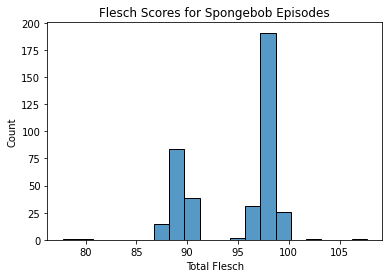

In [13]:
sns.histplot(data = sponge_flesch,
             x = 'Total Flesch',
             bins = 20)
plt.title('Flesch Scores for Spongebob Episodes')
plt.show()

Very strangely, we find a sort of bimodal distribution here. One could only help but wonder if there is a relationship here.

From the above plot, I can see an empty space between 92 and 94, just to confirm it, let's query the dataframe for that range. If there is nothing in there, then let's assign the groups based on those ranges.

In [14]:
sponge_flesch[(sponge_flesch['Total Flesch'] > 92) & (sponge_flesch['Total Flesch'] < 94)]

,Episode #,Title,Rating,Script,Total Flesch


In [15]:
conditions = [
    sponge_flesch['Total Flesch'] < 92,
    sponge_flesch['Total Flesch'] > 94
]

results = ['Lower','Upper']
sponge_flesch['Flesch Division'] = np.select(conditions, results)

Let's see the distribution here:

In [16]:
sponge_flesch['Flesch Division'].value_counts()

Upper    252
Lower    140
Name: Flesch Division, dtype: int64

Now let's see if there is a rating difference between the more complex and less complex episodes by finding the p-value.

In [17]:
print(
    'We have found a p-value of {}'.format(round(
    stats.ttest_ind(sponge_flesch['Rating'][sponge_flesch['Flesch Division'] == 'Upper'],
                sponge_flesch['Rating'][sponge_flesch['Flesch Division'] == 'Lower'])[1]
    ,3)))
               

We have found a p-value of 0.027


Let's get a further look into the distributions!

In [18]:
sponge_flesch.groupby(by = 'Flesch Division')['Rating'].describe()

,count,mean,std,min,25%,50%,75%,max
Flesch Division,,,,,,,,
Lower,140.0,7.082857,1.090241,3.5,6.575,7.1,7.5,9.5
Upper,252.0,7.359921,1.229688,3.2,6.700,7.3,8.5,9.7


So it seems that the simpler the compexity level of the episode, the higher the rating is.

<AxesSubplot:xlabel='Episode #', ylabel='Total Flesch'>

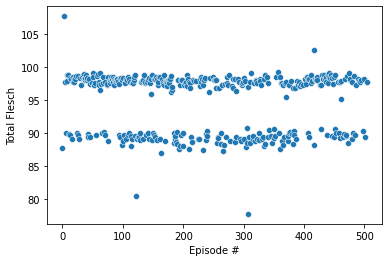

In [19]:
sns.scatterplot(data = sponge_flesch,
                x = 'Episode #',
                y = 'Total Flesch')

<AxesSubplot:xlabel='Episode #', ylabel='Rating'>

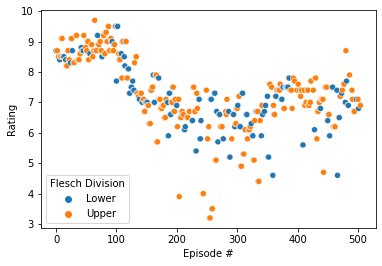

In [20]:
sns.scatterplot(data = sponge_flesch,
                x = 'Episode #',
                y = 'Rating',
                hue = 'Flesch Division')

Both parts of the division here are represented throughout the series, it isn't segmented as one would hypothesize.

Let's look at by per character

In [21]:
lines = []
TEXTO = "SpongeBob"
def get_char_flesch(episode_name,character):
    lines = []
    p = re.compile('(%s)\:'%character)
    for i in list(sponge_df.query("Title == @episode_name").Script)[0]:
        match = re.search(p, i)
        if match:
            new_pattern = re.compile('(?<=(%s)\:).*'%character)
            #if re.search(new_pattern,i):
            lines.append(re.search(new_pattern,i))
    # print(''.join([i.group(0) for i in lines]))
    if lines:
        return textstat.flesch_reading_ease(
            ''.join([i.group(0) for i in lines])
        )

In [22]:
sponge_flesch_chars = sponge_df.copy()
for character in relevant_chars:
    sponge_flesch_chars[character] = \
    sponge_df.Title.apply(get_char_flesch, character = character)


In [23]:
sponge_flesch_chars.fillna(0, inplace = True)
sponge_flesch_chars.head()

,Episode #,Title,Rating,Script,SpongeBob,Mr. Krabs,Squidward,Patrick,French Narrator,Gary,...,Narrator,Harold,Plankton,Karen,SpongeBob and Patrick,Mrs. Puff,Fred,Pearl,Both,Nat
0,0,Help Wanted,8.7,"[French Narrator: Ah, the sea... so fascinatin...",88.74,95.77,94.76,97.91,72.32,36.62,...,72.32,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
2,2,Tea at the Treedome,8.7,"[Sandy Cheeks: Take that, you sorry old clam! ...",108.29,0.00,0.00,98.41,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
4,4,Ripped Pants,8.5,"[Narrator: Ah, Goo. Lagoon. A stinky mud puddl...",97.50,0.00,0.00,0.00,0.00,0.00,...,65.05,116.15,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
6,6,Plankton!,8.4,"[Squidward: Come on, SpongeBob!, SpongeBob: Ne...",89.34,98.31,91.88,0.00,0.00,0.00,...,0.00,0.00,90.16,99.23,0.00,0.0,0.0,0.0,0.0,0.0
7,7,Naughty Nautical Neighbors,8.5,"[Squidward: Wow. Squidward, this is the best s...",98.51,0.00,97.91,97.80,0.00,0.00,...,0.00,0.00,0.00,0.00,89.75,0.0,0.0,0.0,0.0,0.0


Now let's see if there's some sort of correlation

In [24]:

char_pvalues = []
char_upper = []
char_lower = []

for character in relevant_chars:

    char_df = sponge_flesch_chars[['Rating', character]].copy()

    conditions = [
    char_df[character] < 92,
    char_df[character] > 94
]
    results = ['Lower','Upper']

    
    char_df['Division'] = np.select(conditions,results)
    char_df = char_df[char_df[character] > 0]

    char_upper.append(char_df[char_df['Division'] == 'Upper']['Rating'].mean())
    char_lower.append(char_df[char_df['Division'] == 'Lower']['Rating'].mean())


    char_pvalues.append(stats.ttest_ind(char_df['Rating'][char_df['Division'] == 'Upper'],
                char_df['Rating'][char_df['Division'] == 'Lower'])[1]
                )
    #print(character, stats.ttest_ind(char_df['Rating'][char_df['Division'] == 'Upper'],
                #char_df['Rating'][char_df['Division'] == 'Lower'])[1])

    
    

In [25]:
chars_flesch_df_grouped = pd.DataFrame({'Character': relevant_chars,
              'Upper Flesch Group Mean Rating': char_upper,
              'Lower Flesch Group Mean Rating': char_lower,
              'p-values': char_pvalues}).round(3).sort_values(by = 'p-values')

chars_flesch_df_grouped


,Character,Upper Flesch Group Mean Rating,Lower Flesch Group Mean Rating,p-values
5,Gary,9.450,7.212,0.008
2,Squidward,7.394,7.077,0.018
13,SpongeBob and Patrick,7.260,7.854,0.021
6,Sandy,7.475,6.976,0.022
1,Mr. Krabs,7.350,7.023,0.023
9,Narrator,8.175,7.600,0.038
15,Fred,7.622,6.820,0.043
8,Larry,7.747,7.069,0.045
0,SpongeBob,7.310,7.130,0.183
10,Harold,7.203,6.848,0.268


Admittedly, the Flesch score has some flaws. A lot of it is based on syllable count and word count, so longer words will generate a higher Flesch score. When Gary says `Meow—meow—meow—meow—meow—meow—meow. Meow—meow—meow—meow—meow—meow`, that generates a very low Flecsh score of -429.7. I would exclude Gary from this primarily because his vocabulary is limited to different variations of Meowing for all but a few episodes.

In [27]:
sponge_flesch

,Episode #,Title,Rating,Script,Total Flesch,Flesch Division
0,0,Help Wanted,8.7,"[French Narrator: Ah, the sea... so fascinatin...",87.72,Lower
2,2,Tea at the Treedome,8.7,"[Sandy Cheeks: Take that, you sorry old clam! ...",107.69,Upper
4,4,Ripped Pants,8.5,"[Narrator: Ah, Goo. Lagoon. A stinky mud puddl...",97.80,Upper
6,6,Plankton!,8.4,"[Squidward: Come on, SpongeBob!, SpongeBob: Ne...",90.05,Lower
7,7,Naughty Nautical Neighbors,8.5,"[Squidward: Wow. Squidward, this is the best s...",97.91,Upper
...,...,...,...,...,...,...
494,494,The Hankering,6.7,"[Tina Fran: Oh, these are delicious., Jennifer...",98.01,Upper
497,497,Who R Zoo?,7.1,"[SpongeBob: Hey, Timmy! I've found your ball. ...",90.26,Lower
500,500,Biddy Sitting,7.1,"[Squidward: ""SquarePants and Star Babysitting...",98.21,Upper
501,501,Lighthouse Louie,6.8,"[Mrs. Puff: Now, SpongeBob, what is the prope...",89.34,Lower


In [31]:
sponge_flesch_chars.merge(sponge_flesch[['Title', 'Total Flesch']], on = 'Title') \
    .to_csv('full_flesch.csv')